# Install Necessary Libraries

In [5]:
!pip install scrapy selenium pandas beautifulsoup4 cloudscraper -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.9/492.9 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.8/259.8 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 5.2 MB/s eta 0:00:00


# **Task 1** ==========================================================================================

# **Step - 1** : Collect all subcategory pages' links from the category webpage

In [1]:

import time
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By

# Configure Selenium to run headless
chrome_options = Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--disable-gpu")
chrome_options.add_argument("--window-size=1920,1080")

# Initialize the Chrome WebDriver (adjust executable_path if needed)
driver = webdriver.Chrome(options=chrome_options)

# Load the Trustpilot categories page
categories_url = "https://uk.trustpilot.com/categories"
driver.get(categories_url)
time.sleep(3)  # Allow the page to load

# Find all category cards; these cards have a unique class (adjust if needed)
category_cards = driver.find_elements(By.CSS_SELECTOR, "div.styles_card__Z1lPe")
categories_data = []

for card in category_cards:
    try:
        # Extract the parent category type from the heading element
        cat_type_elem = card.find_element(By.CSS_SELECTOR, "h2.styles_headingDisplayName__XN7x3")
        category_type = cat_type_elem.text.strip()
    except Exception as e:
        category_type = None

    try:
        # Locate the list of subcategories within this card.
        # Each subcategory is an <a> tag inside the <ul> with class styles_linkList__C9GRA.
        subcat_elements = card.find_elements(By.CSS_SELECTOR, "ul.styles_linkList__C9GRA li a")
        for subcat in subcat_elements:
            subcat_name = subcat.text.strip()
            subcat_href = subcat.get_attribute("href")
            # If the link is relative, prefix with the base URL.
            if subcat_href.startswith("/"):
                subcat_link = "https://uk.trustpilot.com" + subcat_href
            else:
                subcat_link = subcat_href
            categories_data.append({
                "Link": subcat_link,
                "Subcategory": subcat_name,
                "Category": category_type
            })
    except Exception as e:
        print(f"Error processing a category card: {e}")

# Save the collected category/subcategory links to CSV
df_categories = pd.DataFrame(categories_data)
df_categories.to_csv("trustpilot_categories.csv", index=False)
print(f"Collected {len(df_categories)} category links. Saved to trustpilot_categories.csv")

driver.quit()


Collected 189 category links. Saved to trustpilot_categories.csv


# The subcategory links

In [1]:
import pandas as pd

category_pages = pd.read_csv("trustpilot_categories.csv")
category_pages.head()

,Link,Subcategory,Category Type
0,https://uk.trustpilot.com/categories/animal_he...,Animal Health,Animals & Pets
1,https://uk.trustpilot.com/categories/animal_pa...,Animal Parks & Zoo,Animals & Pets
2,https://uk.trustpilot.com/categories/cats_dogs,Cats & Dogs,Animals & Pets
3,https://uk.trustpilot.com/categories/horses_ri...,Horses & Riding,Animals & Pets
4,https://uk.trustpilot.com/categories/pet_services,Pet Services,Animals & Pets


In [4]:
category_pages.shape

(189, 3)

# **Step - 2** : Collecting business page links from the subcategory pages

In [ ]:

import scrapy
from scrapy.crawler import CrawlerProcess
import pandas as pd


categories_df = pd.read_csv("trustpilot_categories.csv")
start_urls = []
meta_list = []
for idx, row in categories_df.iterrows():
    url = row["Link"]
    meta = {"subcategory": row["Subcategory"], "category": row["Category"], "page": 1}
    # Start at page 1
    start_urls.append(url + "?page=1")
    meta_list.append(meta)

class CardLinkSpider(scrapy.Spider):
    name = "card_links_spider"

    custom_settings = {
        "DOWNLOAD_DELAY": 2,  # Delay between requests (in seconds)
        "AUTOTHROTTLE_ENABLED": True,
        "USER_AGENT": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36",
        "RETRY_ENABLED": True,
        "RETRY_TIMES": 3,
        "LOG_LEVEL": "INFO",
    }

    def start_requests(self):
        for url, meta in zip(start_urls, meta_list):
            yield scrapy.Request(url=url, callback=self.parse_category, meta=meta)

    def parse_category(self, response):
        subcategory = response.meta["subcategory"]
        category = response.meta["category"]
        current_page = response.meta.get("page", 1)

        # Extract business card links (anchor with name 'business-unit-card')
        card_links = response.css("a[name='business-unit-card']::attr(href)").getall()
        if not card_links:
            self.logger.info(f"No card links found on page {current_page} for '{subcategory}'.")
        for link in card_links:
            full_link = response.urljoin(link)
            yield {"Link": full_link, "Subcategory": subcategory, "Category": category}

        # Handle pagination: if card links are found, assume there's a next page.
        if card_links:
            next_page = current_page + 1
            base_url = response.url.split('?')[0]
            next_url = base_url + "?page=" + str(next_page)
            meta = response.meta.copy()
            meta["page"] = next_page
            yield scrapy.Request(url=next_url, callback=self.parse_category, meta=meta)
        else:
            self.logger.info(f"Finished pagination for subcategory '{subcategory}' at page {current_page}.")

process = CrawlerProcess(settings={
    "FEEDS": {
        "trustpilot_card_links.csv": {"format": "csv", "overwrite": True},
    },
    "LOG_LEVEL": "INFO",
    "DOWNLOAD_DELAY": 2,
    "AUTOTHROTTLE_ENABLED": True,
    "USER_AGENT": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36",
    "RETRY_ENABLED": True,
    "RETRY_TIMES": 3,
})
process.crawl(CardLinkSpider)
process.start()  # This call blocks until the crawling is finished.


In [10]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('trustpilot_card_links.csv')
print("Total business links collected", df.shape[0])

Total business links collected 305217


In [11]:
df.head()

,Link,Subcategory,Category
0,https://uk.trustpilot.com/review/joiipetcare.com,Animal Health,Animals & Pets
1,https://uk.trustpilot.com/review/www.beevive.com,Animal Health,Animals & Pets
2,https://uk.trustpilot.com/review/www.travellin...,Animal Health,Animals & Pets
3,https://uk.trustpilot.com/review/thepethealthc...,Animal Health,Animals & Pets
4,https://uk.trustpilot.com/review/beha.vet,Animal Health,Animals & Pets


# **Step - 3** : Removing duplicate links

In [17]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('trustpilot_card_links.csv')

# Remove duplicate rows based on the 'Link' column (keeping the first occurrence)
df_unique = df.drop_duplicates(subset=['Link'], keep='first')

# Save the deduplicated records to a new CSV file
df_unique.to_csv('trustpilot_card_links_unique.csv', index=False)
print(f"Total {df_unique.shape[0]} unique business links found.")


Total 190868 unique business links found.


# **Step - 4** : Scraping business data from the links

Data collected -

*   Name
*   Email
*   Company(Same as name. Added as it was asked to be collected in the task.)
*   Location
*   Phone
*   Website
*   Category
*   Subcategory
*   Review_Count
*   Ratings

## => Here set the amount of records to be collected in MAX_RECORDS. For the task it has been set to 30000.

## => Collected data of companies that has both email and phone number for ease of the process of reaching out

In [ ]:
import csv
import requests
from bs4 import BeautifulSoup
import time

# Configurable constants
INPUT_CSV = 'trustpilot_card_links_unique.csv'
OUTPUT_CSV = 'trustpilot_business_data.csv'
MAX_RECORDS = 30000

def scrape_business_page(url):
    """
    Given a Trustpilot business page URL, scrape the required data:
    Name, Email, Phone, Location, Website, Review_Count, and Ratings.
    Company is set equal to Name.
    """
    headers = {
        'User-Agent': ('Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
                       'AppleWebKit/537.36 (KHTML, like Gecko) '
                       'Chrome/115.0 Safari/537.36')
    }
    try:
        response = requests.get(url, headers=headers, timeout=10)
        if response.status_code != 200:
            print(f"Failed to retrieve {url} (status code: {response.status_code})")
            return None

        soup = BeautifulSoup(response.text, 'html.parser')

        # Extract Name using the dedicated span so it doesn't include review text.
        name_tag = soup.find('span', class_=lambda x: x and 'title_displayName__OBSVU' in x)
        name = name_tag.get_text(strip=True) if name_tag else ''

        # Email: find an <a> tag with href starting with 'mailto:'
        email = ''
        a_mail = soup.find('a', href=lambda x: x and x.startswith('mailto:'))
        if a_mail:
            email = a_mail.get_text(strip=True)

        # Phone: find an <a> tag with href starting with 'tel:'
        phone = ''
        a_tel = soup.find('a', href=lambda x: x and x.startswith('tel:'))
        if a_tel:
            phone = a_tel.get_text(strip=True)

        # Extract Location using the provided CSS selector.
        location = ''
        location_element = soup.select_one(
            "#__next > div > div > main > div > div.styles_pageBackground__iq13o > div.styles_pageWrapper__LFfE_ > div.styles_mainContent__po_Tz.styles_businessInfoContent__x1Dkd > div > div.styles_businessInfoColumnBottom__8xuSg > div.styles_companyDetails__apGKD > ul > li:nth-child(1) > p"
        )
        if location_element:
            location = location_element.get_text(strip=True)

        # Website: look for an <a> tag with an href containing 'utm_source=trustpilot'
        website = ''
        a_web = soup.find('a', href=lambda x: x and 'utm_source=trustpilot' in x)
        if a_web:
            website = a_web['href']

        # Review_Count: from the span with class "styles_reviewsAndRating__Syz6V"
        review_count = ''
        review_count_element = soup.find('span', class_=lambda x: x and 'styles_reviewsAndRating__Syz6V' in x)
        if review_count_element:
            text = review_count_element.get_text(separator=" ", strip=True)
            review_count = text.replace("Reviews", "").strip()

        # Ratings: extract from the rating container using a targeted CSS selector.
        rating = ''
        rating_element = soup.select_one("div.styles_ratingContainer__uB4Ss p.typography_body-l__v5JLj.typography_appearance-subtle__PYOVM")
        if rating_element:
            rating = rating_element.get_text(strip=True)

        # Set Company same as Name (no separate field provided)
        company = name

        return {
            'Name': name,
            'Email': email,
            'Company': company,
            'Location': location,
            'Phone': phone,
            'Website': website,
            'Review_Count': review_count,
            'Ratings': rating,
        }
    except Exception as e:
        print(f"Error scraping {url}: {e}")
        return None

def main():
    stored_records = 0

    # Open input CSV and output CSV in append mode.
    with open(INPUT_CSV, newline='', encoding='utf-8') as infile, \
         open(OUTPUT_CSV, 'a', newline='', encoding='utf-8') as outfile:

        reader = csv.DictReader(infile)
        # CSV columns in the required order.
        fieldnames = ['Name', 'Email', 'Company', 'Location', 'Phone',
                      'Website', 'Category', 'Subcategory', 'Review_Count', 'Ratings']
        writer = csv.DictWriter(outfile, fieldnames=fieldnames)

        # Write header if the output file is empty.
        outfile.seek(0, 2)
        if outfile.tell() == 0:
            writer.writeheader()
            outfile.flush()

        # Iterate over each record in the input CSV.
        for row in reader:
            if stored_records%100==0 and stored_records!=0:
                time.sleep(10)

            if stored_records >= MAX_RECORDS:
                print("Reached maximum record limit. Stopping the script.")
                break

            url = row.get('Link', '')
            subcategory = row.get('Subcategory', '')
            category = row.get('Category', '')

            scraped_data = scrape_business_page(url)
            if scraped_data is None:
                continue

            # Skip records that do not have an Email or a Phone.
            if not scraped_data.get('Email') or not scraped_data.get('Phone'):
                print(f"Skipping {url} because either email or phone is missing.")
                continue

            output_row = {
                'Name': scraped_data.get('Name', ''),
                'Email': scraped_data.get('Email', ''),
                'Company': scraped_data.get('Company', ''),
                'Location': scraped_data.get('Location', ''),
                'Phone': scraped_data.get('Phone', ''),
                'Website': scraped_data.get('Website', ''),
                'Category': category,
                'Subcategory': subcategory,
                'Review_Count': scraped_data.get('Review_Count', ''),
                'Ratings': scraped_data.get('Ratings', ''),
            }

            writer.writerow(output_row)
            outfile.flush()  # Flush after each record.
            stored_records += 1
            print(f"Scraped and saved record #{stored_records} for {url}")

            # Slight delay to avoid overwhelming the server and avoid bot detection.
            time.sleep(1)

if __name__ == '__main__':
    main()


# **Task 2** ==========================================================================================

## Visualize the collected data

In [18]:
business_data = pd.read_csv("trustpilot_business_data.csv")
business_data.head()

,Name,Email,Company,Location,Phone,Website,Category,Subcategory,Review_Count,Ratings
0,The Travelling Pet,leeann@travellingpetvet.co.uk,The Travelling Pet,"Kemp House 152-160 City Road, EC1V 2NX, London...",07869377465,http://www.travellingpet.vet?utm_medium=compan...,Animals & Pets,Animal Health,119,4.9
1,VetMediUK,hello@vetmedi.co.uk,VetMediUK,"Sheepwalk, YO19 6ET, York, United Kingdom",01904463001,http://vetmedi.co.uk?utm_medium=company_profil...,Animals & Pets,Animal Health,137,4.8
2,SmartTrace,hello@smarttrace.org.uk,SmartTrace,"108 OFFICE, 372 OLD STREET, EC1V 9LT, LONDON, ...",01208 420 999,https://smarttrace.org.uk?utm_medium=company_p...,Animals & Pets,Animal Health,"30,810",4.7
3,Animed,support@animeddirect.co.uk,Animed,"CVS House, Owen Road, IP22 4ER, Diss, United K...",01379 640052,http://animed.co.uk?utm_medium=company_profile...,Animals & Pets,Animal Health,"331,387",4.6
4,Pet Drugs Online,contact@petdrugsonline.co.uk,Pet Drugs Online,"Pet Drugs Online, Unit 7B, Burnett Business Pa...",01761 603 141,http://www.petdrugsonline.co.uk?utm_medium=com...,Animals & Pets,Animal Health,"17,982",4.6


# First select the top rated companies to send automated email based on ratings and reviews_count.

In [20]:
import pandas as pd

# Load CSV and filter top-rated companies
df = pd.read_csv("trustpilot_business_data.csv")
df["Ratings"] = pd.to_numeric(df["Ratings"], errors="coerce")
top_companies = df.sort_values(by=["Ratings", "Review_Count"], ascending=[False, False]).head(20)
top_companies.head()

,Name,Email,Company,Location,Phone,Website,Category,Subcategory,Review_Count,Ratings
186,Tax Driven Accountants,info@taxdriven.co.uk,Tax Driven Accountants,"Unit 4, Ffordd Richard Davies, St Asaph Busine...",0800 999 1800,https://www.taxdriven.co.uk/?utm_medium=compan...,Business Services,HR & Recruiting,929,5.0
177,Xpressdoctor,trustpilot@xpressdoctor.com,Xpressdoctor,Cyprus,UK +44 (0)20 3239 8452 (local rate) - DE +49 0...,https://xpressdoctor.com?utm_medium=company_pr...,Business Services,Associations & Centers,913,5.0
88,Snip-its of West End,angela@snip-its.co.uk,Snip-its of West End,"81 High Street, SO30 3DS, West End, United Kin...",02380473174,http://snip-its.co.uk?utm_medium=company_profi...,Beauty & Well-being,Hair Care & Styling,907,5.0
1352,Este Medical Group Ltd,info@estemedicalgroup.uk,Este Medical Group Ltd,"9, Portland Road, Edgbaston, B16 9HN, Birmingh...",0121 572 7474,http://www.estemedicalgroup.uk?utm_medium=comp...,Beauty & Well-being,Hair Care & Styling,"9,136",5.0
4626,Move motorcycles,Quotes@movemotorcycles.co.uk,Move motorcycles,"Kemp House 152 - 160 City Road , EC1V2NX, Lond...",07772 024763,http://movemotorcycles.co.uk?utm_medium=compan...,Business Services,Shipping & Logistics,896,5.0


# Send the email



*   First generate the custom email to be sent to the client using Gemini model
*   Then send the email in a controlled manner



In [24]:

import smtplib
import pandas as pd
import time
import random
import os
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from google import genai
from google.genai import types



# Email Configuration
SMTP_SERVER = "smtp.gmail.com"
SMTP_PORT = 587
EMAIL_ADDRESS = ""  # Replace with your email
EMAIL_PASSWORD = ""  # Use your Gmail App Password

# Gemini API Client
client = genai.Client(api_key="") # Use your Gemini API Key

def generate_email_content(name, company):
    """Generate a personalized email using Gemini AI."""
    model = "gemini-2.0-flash"
    prompt = f"""
    Generate a professional cold email(without subject) for {company}.
    The sender is Shah Rukh Khan(Lead Generation Specialist) Ray Advertising (https://www.rayadvertising.com/), a digital marketing agency
    that helps businesses improve their online reputation and increase customer conversions.
    Address the email to {name} and make it engaging, warm, and persuasive with a clear CTA.
    """

    contents = [types.Content(role="user", parts=[types.Part.from_text(text=prompt)])]

    generate_content_config = types.GenerateContentConfig(
        temperature=1,
        top_p=0.95,
        top_k=40,
        max_output_tokens=8192,
        response_mime_type="text/plain",
    )

    response_text = ""
    for chunk in client.models.generate_content_stream(
        model=model,
        contents=contents,
        config=generate_content_config,
    ):
        response_text += chunk.text  # Collecting the response in full

    return response_text.strip()

def send_email(to_email, name, company):
    """Send an email with a Gemini-generated body."""
    subject = f"Let's Boost {company}'s Trustpilot Reputation!"
    body = generate_email_content(name, company)

    msg = MIMEMultipart()
    msg['From'] = EMAIL_ADDRESS
    msg['To'] = to_email
    msg['Subject'] = subject
    msg.attach(MIMEText(body, 'plain'))

    try:
        with smtplib.SMTP(SMTP_SERVER, SMTP_PORT) as server:
            server.starttls()
            server.login(EMAIL_ADDRESS, EMAIL_PASSWORD)
            server.sendmail(EMAIL_ADDRESS, to_email, msg.as_string())
        print(f"Email sent to {to_email}")
    except Exception as e:
        print(f"Failed to send email to {to_email}: {e}")

# Controlled Email Sending (Avoiding Spam Detection)
emails_sent = 0
for index, row in top_companies.iterrows():
    if emails_sent >= 10:  # Introducing extra delay to avoid Gmail limits
        time.sleep(100)
    if pd.notna(row['Email']):
        send_email(row['Email'], row['Name'], row['Company'])
        emails_sent += 1
        time.sleep(random.uniform(30, 120))  # Random delay between emails (30s - 2 min)





Email sent to ahmedanwar.aa872@gmail.com


## Demo email sent

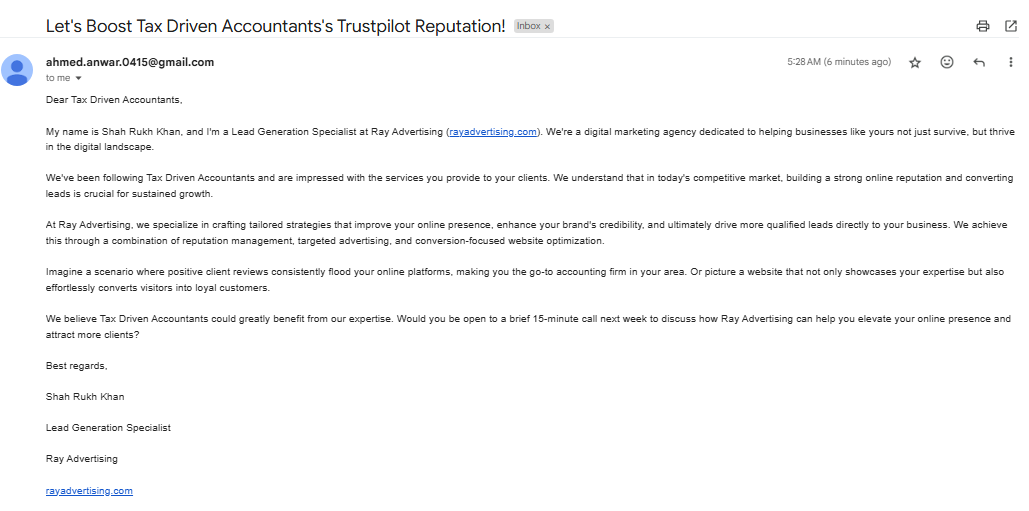